# ML в Биологии
## Transfer learning


In [2]:
!pip install lightning
!pip install tensorboard
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 114.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 555.1/555.1 kB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import os
import gc
import time
import glob
import requests
from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F

import lightning.pytorch as pl
from torchmetrics.functional import accuracy
from lightning.pytorch import loggers as pl_loggers
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping

import torchvision
from torchvision import transforms

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2, style='whitegrid')

# device_num = 0
# torch.cuda.set_device(device_num)

In [4]:
device = f"cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print(device)

cuda


## 2. Transfer Learning <a id=trans></a>

**Transfer Learning** &mdash; это процесс дообучения на *новых данных* какой-либо нейросети, предобученной до этого на других данных. Обычно предобучение производят на хорошем, большом  датасете размером около миллиона картинок, например, ImageNet ~ 14 млн картинок.

На данный момент есть множество предобученных моделей: `AlexNet`, `DenseNet`, `ResNet`, `VGG`, `Inception` и другие, а также их различные модификации. Все они отличаются архитектурой и входными данными.

### 2.1 Описание метода:

Представим, что eсть новый набор данных, и вы хотите научить сеть классифицировать объекты из этой выборки.  

* **1. Fine Tuning / дообучение**  
   * Берём сеть, обученную на ImageNet.
   * Убираем последние Fully-Connected слои сети, отвечающие за классификацию.
   * Замораживаем веса только нескольких первых слоев сети (`param.requires_grad = False`). Последние веса оставляем обучаемыми.
   * Добавляем свои если если нужно. Например, пару FC-слоёв.
   * Обучаем получившуюся архитектуру на новых данных.

* **2. Feature Extractor / средство для извлечения признаков**
    * Берём сеть, обученную на ImageNet.
    * Убираем последние Fully-Connected слои сети, отвечающие за классификацию.
    * Замораживаем (`param.requires_grad = False`) веса всех предыдущих слоёв.
    * Добавляем свои сли если нужно. Например, пару FC-слоёв.
    * Обучаем на выходах полученной сети свой классификатор (пару FC-слоёв, например) на новых данных.

Ниже эти подходы изображены на примере VGG архитектуры:
    
<img src="https://sun9-66.userapi.com/c857632/v857632819/1ea161/rtU9L7NIrag.jpg" alt="tfl" width="600"/>

<style>
div.input {

В зависимости от количества и природы Ваших данных есть выбор из **нескольких стратегий Transfer Learning**, а именно:

* *У Вас **мало данных** ($\le 10k$), и они **похожи** на данные, на которых была обучена сеть до этого*  

    * если данные совсем похожи, можно попробовать использовать готовую модель
    * если качество Вас не устраивает, то тогда стоит обратиться к методу Feature Extractor
    * Fine Tuning лучше не использовать. Так как данные похожи на те, на которых обучалась сеть, то высокоуровневые признаки, полученные с помощью последних слоёв сети, должны оказаться информативными. Если делать в этом случае Fine-Tuning, то сеть может переобучиться, поскольку данных мало

* *У Вас **мало данных** ($\le 10k$), и они **не похожи** на данные, на которых была обучена сеть до этого*  
    * в данном случае мы *не можем* ожидать от сети, что выходы последних слоёв будут информативными для новых данных. Следует использовать Feature Extractor, но брать как признаки выходы более ранних слоёв. Ведь, как ожидается, они соответствуют более общим паттернам в данных.
* *У Вас **много данных** ($\ge 10k$), и они **похожи** на данные, на которых была обучена сеть до этого*  
    * можно попробовать использовать готовую модель
    * если качество Вас не устраивает, то тогда стоит cделать Fine-Tuning, ведь данных много, и вероятность переобучения меньше. Имеет смысл попробовать разморохить веса последних нескольких слоёв (можно разморозить и всю сеть)
* *У Вас **много данных** ($\ge 10k$), и они **не похожи** на данные, на которых была обучена сеть до этого*
    * Fine-Tuning практически всей сети. Веса предобученной сети оставляют в качестве инициализации для обучения на новых данных
    
display:none;
}
</style>

В зависимости от нового датасета имеет смысл использовать разные стратегии дообучения:
- если датасет *похож* на тот, на котором модель предобучена, то возможно стоит просто заменить слои классификации;
- если датасет *не похож*, то возможно стоит разморозить и сверточные слои тоже.

**Эмпирическое правило**: *чем больше новый датасет не похож* на тот, на котором обучали модель, *тем больше слоев с конца стоит размораживать*.

Если новый датасет достаточно большой (на каждый класс > 1000 изображений), то можно попробовать разморозить всю нейросеть и обучить со случайных весов, как мы это делали до того, как узнали про Transfer Learning.

Рассмотрим [**ResNet34**](https://arxiv.org/abs/1512.03385), предобученную на одном из самых крупных датасетов картинок ImageNet, который содержит 1000 классов. Подробнее про данный датасет можно почитать [здесь](http://image-net.org/).

Архитектура **ResNet34** основана на residual connections, которые позволяют избежать затухания градиентов:

![](https://sun9-72.userapi.com/c855620/v855620860/204ab7/DHbavFbU7QU.jpg)

### 2.2 Изучение модели

Загрузим предобученную модель.

In [5]:
from torchvision.models import resnet34

model = resnet34(pretrained=True)  # скачиваем предобученные веса

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 190MB/s]


In [6]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Посмотрим на веса сверток на первом слое. Так как модель предобучена, то они веса уже имеют определенную структуру.

Веса первого слоя ResNet34. Размер слоя: torch.Size([64, 3, 7, 7])


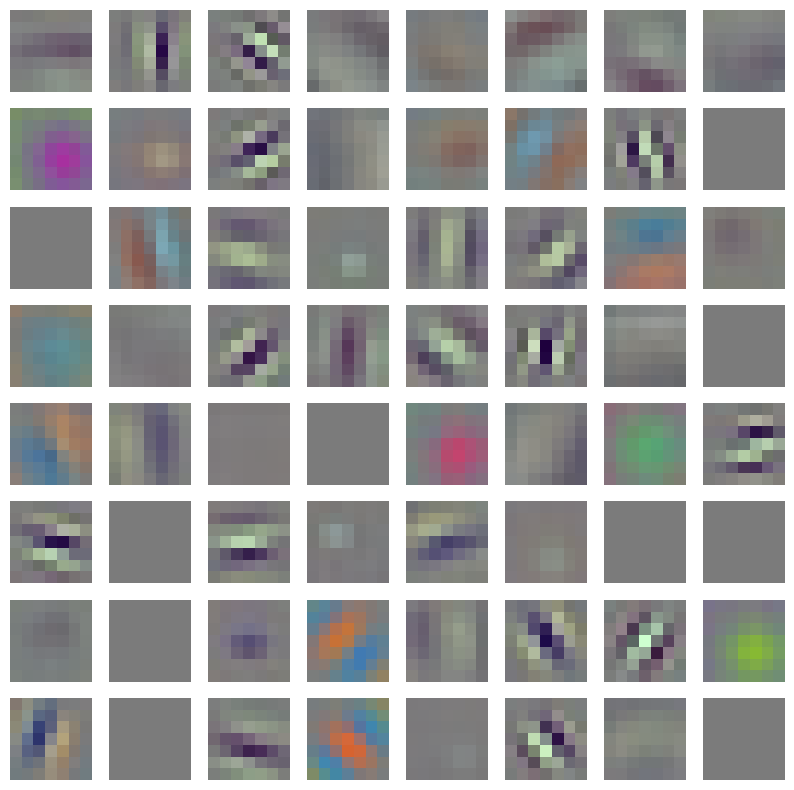

In [7]:
# Минимальные и максимальные значения весов в слое.
max_val = model.conv1.weight.max().detach()
min_val = model.conv1.weight.min().detach()
# Нормировка весов для корректного отображения
weight = (model.conv1.weight - min_val) / (max_val - min_val)
print(f"Веса первого слоя ResNet34. Размер слоя: {weight.shape}")

plt.figure(figsize=(10, 10))
for i, filter in enumerate(weight):
    plt.subplot(8, 8, i + 1)
    plt.imshow(filter.permute(1, 2, 0).detach().cpu())
    plt.axis("off")

Кратко **объясните**, как вы понимаете то, что мы только что получили.

**Ответ:**

На первых слоях наша cетка смогла выявить наибоее простые паттерны такие как: палочки, круги и т.д. Также становится понятно то скорее всего мы применяли свертки для нахожденмя границ изображений.

Т.о. при дальнейшем более глубоком обучении наша сеть бует выявлять более интересные и сложне паттерны.

### 2.3 Transfer Learning на практике: СIFAR10

На прошлом семинаре мы строили свёрточную нейросеть для задачи классификации и обучали её на датасете СIFAR10. Напоминание: датасет состоит из 60k картинок 32х32х3.

50k &mdash; обучающая выборка, 10k &mdash; тестовая.

 ![](https://sun9-72.userapi.com/c857216/v857216523/12dbca/vdSCet5LS_0.jpg)

У вас должны были получиться подобные результаты:

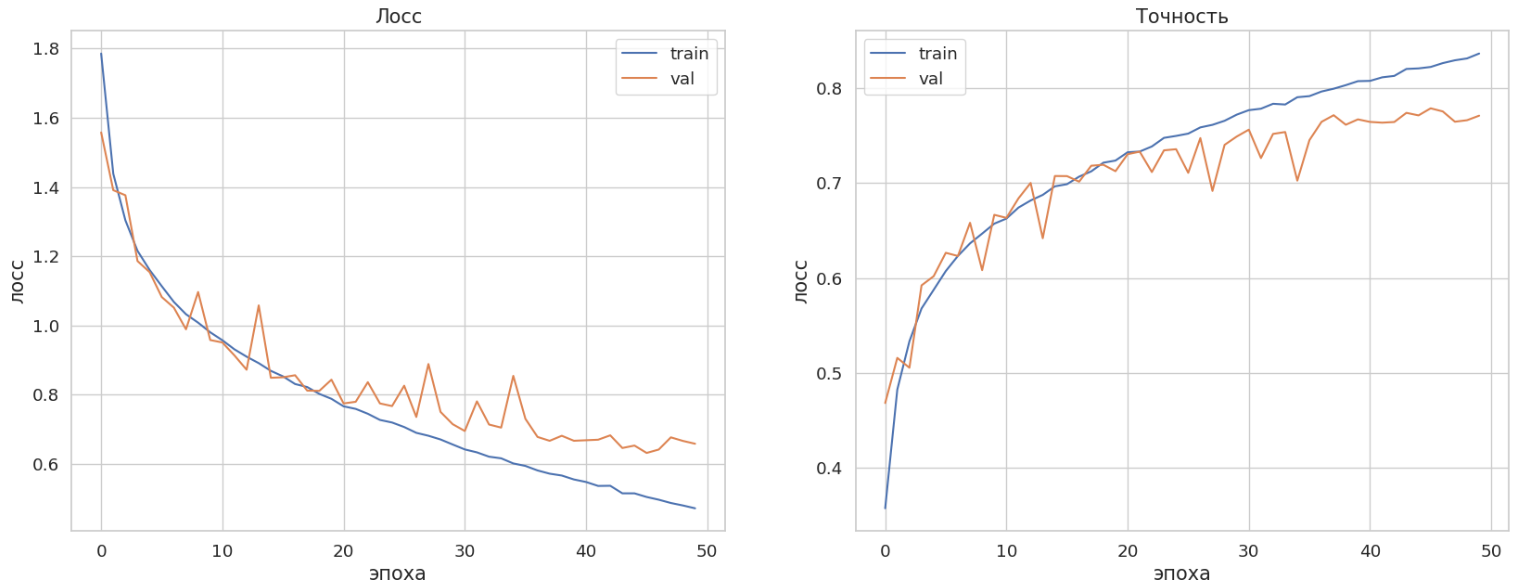

Далее отдельно рассмотрим, как можно применять предобученную нейронную сеть `resnet34` используя оба вышеупомянутых подхода. В целях экономии времени на семинаре, не запускайте ячейки с обучением в этом блоке. Все остальные ячейки можно смело запускать.

❗При использовании предобученных моделей нужно для начала изучать особенности их обучения. Например, при обучении `resnet34` использовалась следующая последовательность преобразований:

1. Ресайз изображения до размера 256 с помощью билинейной интерполяции
2. Центральная обрезка до размера 224
3. Перевод на отрезок [0.0, 1.0]
4. Нормализация со средним mean=[0.485, 0.456, 0.406] и дисперсией std=[0.229, 0.224, 0.225]

Рекомендуется делать эти же преобразования и при кастомном использовании `resnet34`. К счастью, они уже реализованы в torch:

In [9]:
transform = torchvision.models.ResNet34_Weights.IMAGENET1K_V1.transforms()
transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [10]:
# Загрузим часть данных для обучения
dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
# Разделим выборку на обучение и валидацию
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [40000, 10000])

# Загрузим тестеовую часть данных
test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [01:03<00:00, 2696639.03it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Посмотрим на упомянутые преобразования:

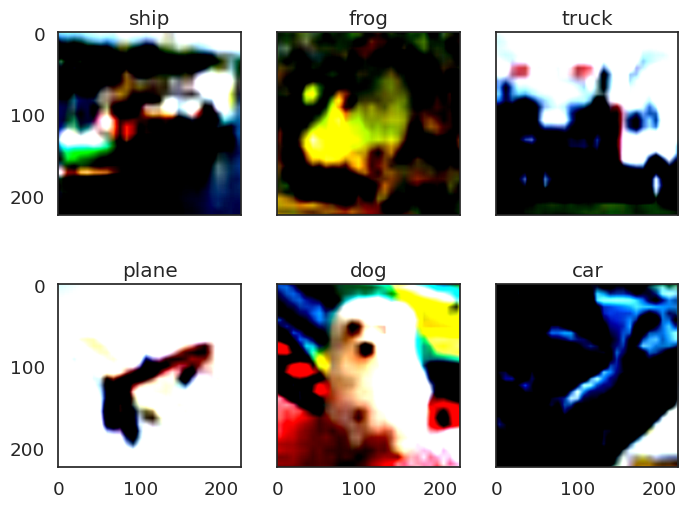

In [12]:
sns.set_style(style='white')

fig, ax = plt.subplots(
    nrows=2, ncols=3, figsize=(8, 6),
    sharey=True, sharex=True
)

for fig_x in ax.flatten():
    idx = np.random.randint(low=0, high=6000)
    img, label = val_dataset[idx]
    fig_x.set_title(classes[val_dataset[idx][1]])
    fig_x.imshow(img.numpy().transpose((1, 2, 0)))

Что ж... странно, но создателям резнета виднее.

Инициализируем генераторы батчей:

In [13]:
batch_size = 32

train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_batch_gen = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### 2.3.1 Fine Tuning (с полной разморозкой)

Добавляем новые слои классификации под датасет CIFAR10:

In [14]:
fine_tuning_model = nn.Sequential()

# предобученная на датасете ImageNet нейросеть ResNet34
fine_tuning_model.add_module('resnet', resnet34(pretrained=True))

# добавляем 2 FC слоя после выходов предобученной неросети
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 10))

# чистка видеокарты
torch.cuda.empty_cache()
gc.collect()

fine_tuning_model = fine_tuning_model.to(device)

Убедимся, что все параметры сети "разморожены", то есть являются обучаемыми:

In [15]:
for param in fine_tuning_model.parameters():
    assert(param.requires_grad)
    # assert(param.is_cuda)

**✏️ Замечание-рекомендация✏️**

Когда запускаете обучение тяжёлой модели, может возникнуть ошибка:

```
OutOfMemoryError: CUDA out of memory.
```
Это значит что вы исчерпали всю предоставленную вам оперативную память GPU. В таком случае:


1. Убедитесь, что вы зануляете градиенты после очередного шага оптимизатора и оборачиваете валидацию в тело "`with torch.no_grad():`"
2.   Перезапустите среду выполнения. Возможно, после предыдущего запуска, в результате, например, аварийного завершения или ещё по каким-то причинам, на видеокарте остались старые данные.
3. Для уверенности, что перед обучением на видеокарте точно нет мусора, очищайте кэш:


```
import gc
torch.cuda.empty_cache()
gc.collect()
```



Зафайнтюним наконец получившуюся модель на наших данных:

In [16]:
class MySimpleModelLightning(pl.LightningModule):
    def __init__(self, model_, lr=0.01, n_classes=10):
        super().__init__()

        self.criterion = nn.CrossEntropyLoss()
        self.lr = lr
        self.n_classes = n_classes
        self.save_hyperparameters() # сохраним гиперпараметры
        self.model = model_

    def forward(self, x):
        '''Forward pass'''
        return self.model(x)

    def training_step(self, batch, batch_idx):
        '''Возвращает лосс с 1 шага обучения по батчу'''
        _, loss, acc = self.__get_preds_loss_accuracy(batch)

        # Логируем лосс и метрику
        self.log('train_loss', loss)
        self.log('train_accuracy', acc)
        return loss

    def validation_step(self, batch, batch_idx):
        '''Используется для логирования метрик'''
        preds, loss, acc = self.__get_preds_loss_accuracy(batch)

        # Логируем лосс и метрику
        self.log('val_loss', loss)
        self.log('val_accuracy', acc)

        # Возвращаем предсказания, чтобы использовать их в callback
        return preds

    def configure_optimizers(self):
        '''определяет оптимизатор модели'''
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def __get_preds_loss_accuracy(self, batch):
        '''вспомогательная функция для шага обучения / валидации'''
        x, y = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        loss = self.criterion(logits, y)
        acc = accuracy(preds, y, 'multiclass', num_classes=self.n_classes)
        return preds, loss, acc

In [17]:
tb_logger = pl_loggers.TensorBoardLogger(save_dir="lightning_logs/resnet-34")

# инициализируем модель
model_resnet34 = MySimpleModelLightning(model_=fine_tuning_model)

# Создаем чекпоинтер
checkpoint_callback = ModelCheckpoint(monitor='val_accuracy', mode='max')
# Создаем коллбек для остановки обучения в случае отсутствия улучшений:
early_stopping = EarlyStopping('val_loss')

trainer = pl.Trainer(
    logger=tb_logger,
    callbacks=[checkpoint_callback,
               early_stopping,],
    accelerator="gpu",
    max_epochs=10)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'model_' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model_'])`.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model_resnet34, train_batch_gen, val_batch_gen)

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

### 2.3.2 Feature Extractor (с практически полной заморозкой).
Импортируем ResNet заново:

In [18]:
feature_extractor_model = resnet34(pretrained=True)

"Замораживаем" все веса всех слоев:

In [19]:
for param in feature_extractor_model.parameters():
    param.requires_grad = False

Последний слой ResNet34 переводит выход основной части модели в вектор размерности 1000:

In [20]:
feature_extractor_model.fc

Linear(in_features=512, out_features=1000, bias=True)

У нас классов всего 10, поэтому заменим последний слой, сделав его обучаемым:

In [21]:
feature_extractor_model.fc = nn.Linear(512, len(classes))
feature_extractor_model.fc

Linear(in_features=512, out_features=10, bias=True)

In [22]:
for param in feature_extractor_model.fc.parameters():
  assert param.requires_grad

Снова инициализируем даталоадеры, так как они являются генераторами:

In [23]:
train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

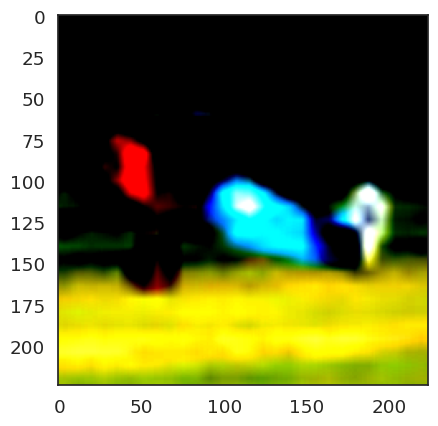

In [24]:
plt.imshow(val_dataset[0][0].numpy().transpose((1, 2, 0)))

Дообучим ResNet под наши данные:

In [ ]:
torch.cuda.empty_cache()
gc.collect()

In [ ]:
tb_logger = pl_loggers.TensorBoardLogger(save_dir="lightning_logs/resnet-34_frozen")

# инициализируем модель
model_resnet34_frozen = MySimpleModelLightning(model_=feature_extractor_model)

# Создаем чекпоинтер
checkpoint_callback = ModelCheckpoint(monitor='val_accuracy', mode='max')
# Создаем коллбек для остановки обучения в случае отсутствия улучшений:
early_stopping = EarlyStopping('val_loss')

trainer = pl.Trainer(
    logger=tb_logger,
    callbacks=[checkpoint_callback,
               early_stopping,],
    accelerator="gpu",
    max_epochs=10)

In [ ]:
trainer.fit(model_resnet34_frozen, train_batch_gen, val_batch_gen)

## 2.3 Практика по transfer learning

Скачайте предобученную `resnet18` и используйте ее в качестве feature extractor.

In [35]:
from torchvision.models import resnet18

model = resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
transform = torchvision.models.ResNet18_Weights.IMAGENET1K_V1.transforms()

Снова загрузите датасет и инициализируйте даталоадеры:

In [36]:
# Загрузим часть данных для обучения
dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
# Разделим выборку на обучение и валидацию
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [40000, 10000])

# Загрузим тестеовую часть данных
test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [37]:
batch_size = 32

train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_batch_gen = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Создайте модель обучите её на ОДНОЙ эпохе с параметром Trainer(limit_train_batches=0.1).

In [38]:
fine_tuning_model = nn.Sequential()

# Добавляем предобученную ResNet18 как feature extractor
resnet = resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
for param in resnet.parameters():
    param.requires_grad = False  # Заморозим веса

# Удаляем последний fully connected слой и добавляем новые слои для нашей задачи
resnet = nn.Sequential(*list(resnet.children())[:-1])
fine_tuning_model.add_module('resnet', resnet)
fine_tuning_model.add_module('flatten', nn.Flatten())
fine_tuning_model.add_module('fc_1', nn.Linear(512, 512))
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 10))  # 10 классов в CIFAR-10

# Освобождаем память GPU
torch.cuda.empty_cache()
gc.collect()

# Установка на устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fine_tuning_model = fine_tuning_model.to(device)

In [39]:
class MySimpleModelLightning(pl.LightningModule):
    def __init__(self, model_, lr=0.01, n_classes=10):
        super().__init__()
        self.criterion = nn.CrossEntropyLoss()
        self.lr = lr
        self.n_classes = n_classes
        self.save_hyperparameters()  # Сохраняем гиперпараметры
        self.model = model_

    def forward(self, x):
        '''Forward pass'''
        return self.model(x)

    def training_step(self, batch, batch_idx):
        '''Возвращает лосс на шаге обучения'''
        _, loss, acc = self.__get_preds_loss_accuracy(batch)
        # Логируем лосс и метрику
        self.log('train_loss', loss)
        self.log('train_accuracy', acc)
        return loss

    def validation_step(self, batch, batch_idx):
        '''Используется для логирования метрик на шаге валидации'''
        preds, loss, acc = self.__get_preds_loss_accuracy(batch)
        # Логируем лосс и метрику
        self.log('val_loss', loss)
        self.log('val_accuracy', acc)
        # Возвращаем предсказания, чтобы использовать их в callback
        return preds

    def configure_optimizers(self):
        '''Определяем оптимизатор'''
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def __get_preds_loss_accuracy(self, batch):
        '''Вспомогательная функция для получения предсказаний, лосса и точности'''
        x, y = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        loss = self.criterion(logits, y)
        acc = accuracy(preds, y, task='multiclass', num_classes=self.n_classes)
        return preds, loss, acc

In [40]:
tb_logger = pl_loggers.TensorBoardLogger(save_dir="lightning_logs/resnet-18")

# Инициализация модели для Lightning
model_resnet18 = MySimpleModelLightning(model_=fine_tuning_model)

# Чекпоинт для сохранения модели
checkpoint_callback = ModelCheckpoint(monitor='val_accuracy', mode='max')

# Раннее остановление
early_stopping = EarlyStopping('val_loss')

# Инициализация тренера
trainer = pl.Trainer(
    limit_train_batches=0.1,
    logger=tb_logger,
    callbacks=[checkpoint_callback, early_stopping],
    accelerator="gpu",
    max_epochs=1
)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'model_' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model_'])`.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [41]:
trainer.fit(model_resnet18, train_batch_gen, val_batch_gen)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | criterion | CrossEntropyLoss | 0      | train
1 | model     | Sequential       | 11.4 M | train
-------------------------------------------------------
267 K     Trainable params
11.2 M    Non-trainable params
11.4 M    Total params
45.777    Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | criterion | CrossEntropyLoss | 0      | train
1 | model     | Sequential       | 11.4 M | train
-------------------------------------------------------
267 K     Trainable params
11.2 M    Non-trainable params
11.4 M    Total params
45.777    Total 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [44]:
#%reload_ext tensorboard
#%tensorboard --logdir=lightning_logs/resnet-18

**Вывод:**

Во, нормалек, accuracy == 0.6335 и это на 1-ой эпохе, что быльше чем на 10 эпохах в случае CNN. Т.о. брпть веса с более крутой модели и дообучать на похожешь задаче - тема)